# Natural Computing for the coursework. 

In [1]:
import numpy as np 
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random
from time import process_time  # to time processes by time scales and not # of iterations

# Exercise 1: Analysis of Particle Swarm Optimisation. 

### We start by defining the sphere, rastrigin and the particle class

In [2]:
def sphere(x):
    return x.dot(x)
#This defines the sphere function to be minimised by the canonical PSO algorithm. 

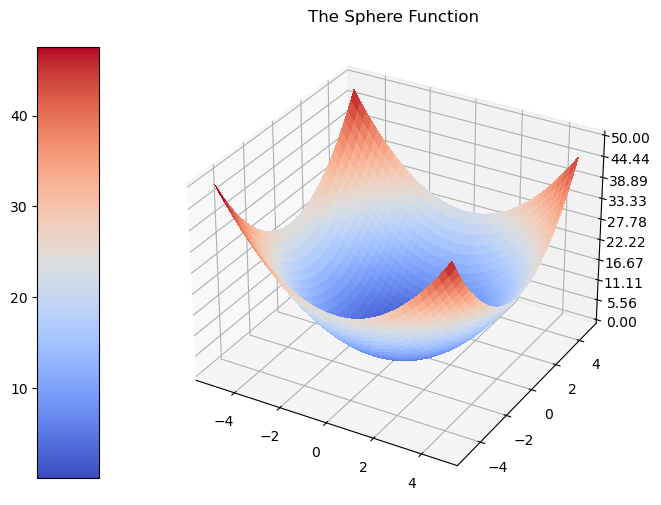

<Figure size 640x480 with 0 Axes>

In [50]:
# We give a picture of the sphere function: 
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(figsize=(8,8),subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X**2+Y**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.7, aspect=7,location = 'left')
plt.title("The Sphere Function")
plt.show()
plt.savefig("The Sphere.png")

In [3]:
def rastrigin(x):
    return 10*len(x)+sum(x**2-10*np.cos(2*np.pi*x))
#This is the rastigin function to be as well minimised by the canonical PSO algortihm.

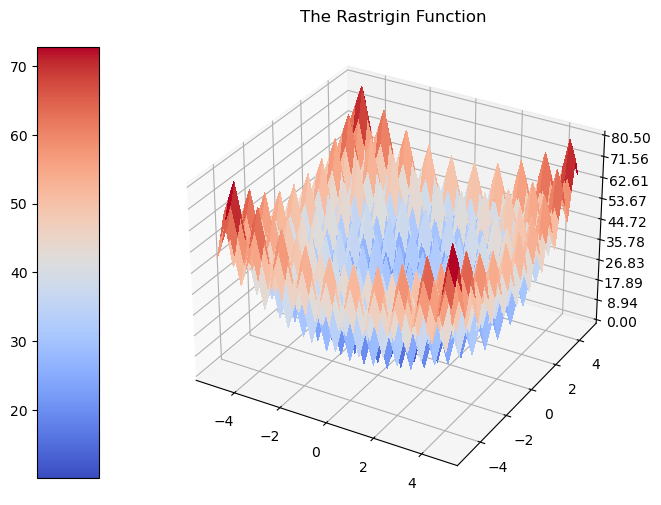

<Figure size 640x480 with 0 Axes>

In [6]:
# We give a picture of the Rastrigin function: 
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(figsize=(8,8),subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = 20+(X**2-10*np.cos(2*np.pi*X))+(Y**2-10*np.cos(2*np.pi*Y))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.7, aspect=7, location="left")
plt.title("The Rastrigin Function")
plt.show()

plt.savefig("The Rastigin.png")

In [5]:
class Particle: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx, funct):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim
        self.funct=funct
        self.fitness = self.funct(self.position)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = self.funct(pos)  #WATCH OUT WITH THIS LINE: IS IT self.position or just pos?
        
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, best_self_pos, best_swarm_pos):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
                    # the next line is the main equation, namely the velocity update, 
                    # the velocities are added to the positions at swarm level
        new_vel = inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)
        self.velocity = new_vel
        return new_vel
    
    

#In these lines of codes, I add another argument to the particle class created in the labs, which determines the function in which our swarm particles are evaluated. 
#Hence, when optimising a particular function f, we will call our particles with funct=f.

### We see the original PSO class imported from the tutorial notebooks 

In [53]:

class PSO: # all the material that is relavant at swarm leveel

    def __init__(self, w, a1, a2, dim, population_size, time_steps, search_range, f):

        # Here we use values that are (somewhat) known to be good
        # There are no "best" parameters (No Free Lunch), so try using different ones
        # There are several papers online which discuss various different tunings of a1 and a2
        # for different types of problems
        self.w = w # Inertia
        self.a1 = a1 # Attraction to personal best
        self.a2 = a2 # Attraction to global best
        self.dim = dim
        self.f=f

        self.swarm = [Particle(dim,-search_range,search_range, f) for i in range(population_size)]
        self.time_steps = time_steps
        print('init')

        # Initialising global best, you can wait until the end of the first time step
        # but creating a random initial best and fitness which is very high will mean you
        # do not have to write an if statement for the one off case
        self.best_swarm_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarm_fitness = 1e100

    def run(self):
        for t in range(self.time_steps):
            for p in range(len(self.swarm)):
                particle = self.swarm[p]

                new_position = particle.position + particle.updateVel(self.w, self.a1, self.a2, particle.best_particle_pos, self.best_swarm_pos)
                                
                if new_position.dot(new_position) > 1.0e+18: # The search will be terminated if the distance 
                                                        # of any particle from center is too large
                    print('Time:', t,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                    raise SystemExit('Most likely divergent: Decrease parameter values')
 
                self.swarm[p].setPos(new_position)         #When executing this recall that you are also maybe updating the value of the particle's best.

                new_fitness = self.f(new_position)

                if new_fitness < self.best_swarm_fitness:   # to update the global best both 
                                                            # position (for velocity update) and
                                                            # fitness (the new group norm) are needed
                    self.best_swarm_fitness = new_fitness
                    self.best_swarm_pos = new_position

            if t % 20 == 0: #we print only two components even it search space is high-dimensional
                print("Time: %6d,  Best Fitness: %14.6f,  Best Pos: %9.4f,%9.4f" % (t,self.best_swarm_fitness,self.best_swarm_pos[0],self.best_swarm_pos[1]), end =" ")
                if self.dim>2: 
                    print('...')
                else:
                    print('')


In [7]:
PSO(0.7,2.0,2.0,3,25,500,100,sphere).run()#Trial for minimising the sphere function with w=0.7, a1,a2=2 so that a1+a2=4

init
Time:      0,  Best Fitness:    8328.491761,  Best Pos:   80.6576, -37.2224 ...
Time:     20,  Best Fitness:     625.964558,  Best Pos:   15.9770,  10.5059 ...
Time:     40,  Best Fitness:       5.522148,  Best Pos:   -0.9925,  -0.1133 ...
Time:     60,  Best Fitness:       0.777387,  Best Pos:   -0.7522,  -0.2544 ...
Time:     80,  Best Fitness:       0.259145,  Best Pos:   -0.5028,   0.0741 ...
Time:    100,  Best Fitness:       0.076253,  Best Pos:   -0.2265,   0.1468 ...
Time:    120,  Best Fitness:       0.001144,  Best Pos:   -0.0246,  -0.0211 ...
Time:    140,  Best Fitness:       0.000023,  Best Pos:    0.0042,   0.0022 ...
Time:    160,  Best Fitness:       0.000001,  Best Pos:    0.0002,   0.0009 ...
Time:    180,  Best Fitness:       0.000000,  Best Pos:   -0.0004,   0.0004 ...
Time:    200,  Best Fitness:       0.000000,  Best Pos:    0.0000,   0.0000 ...
Time:    220,  Best Fitness:       0.000000,  Best Pos:    0.0000,   0.0000 ...
Time:    240,  Best Fitness:       

### The code for a PSO class which has a termination criterion given by either time or closeness to the global optimum.

In [6]:

class PSO: # all the material that is relavant at swarm leveel

    def __init__(self, w, a1, a2, dim, population_size, search_range, f, termination):

        # Here we use values that are (somewhat) known to be good
        # There are no "best" parameters (No Free Lunch), so try using different ones
        # There are several papers online which discuss various different tunings of a1 and a2
        # for different types of problems
        self.w = w # Inertia
        self.a1 = a1 # Attraction to personal best
        self.a2 = a2 # Attraction to global best
        self.dim = dim
        self.f=f
        self.termination=termination # a termination threeshold.
        self.swarm = [Particle(dim,-search_range,search_range, self.f) for i in range(population_size)]

        # Initialising global best, you can wait until the end of the first time step
        # but creating a random initial best and fitness which is very high will mean you
        # do not have to write an if statement for the one off case
        self.best_swarm_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarm_fitness = 1e100

    def run(self): 
        time=0
        diver=0
        while self.best_swarm_fitness>self.termination:
            time=time+1
            for p in range(len(self.swarm)):
                particle = self.swarm[p]

                new_position = particle.position + particle.updateVel(self.w, self.a1, self.a2, particle.best_particle_pos, self.best_swarm_pos)
                                
                if new_position.dot(new_position) > 1.0e+18: # The search will be terminated if the distance 
                                                        # of any particle from center is too large
                        # We would want parameters for which our swarm does not diverge. As we also do not want 
                        # parameter settings producing time consuming runs, we group these two options by making divergent swarms look as time consuming runs
                        #print('Time:', time,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                        #This will tell us whether the swarm diverged or not.
                        #'Most likely divergent: Decrease parameter values'
                    diver=1
                    return [None, diver] #if our new particle position is too far apart, we simply return a None time value and a 1 divergence value.
                        #This will state that most likely our swarm diverged and consequently there is no proper convergence of the swarm.
                
                if time==1000: 
                    return [None,1]# To avoid to much time running.
                
                self.swarm[p].setPos(new_position)         #When executing this recall that you are also maybe updating the value of the particle's best.

                new_fitness = self.f(new_position)

                if new_fitness < self.best_swarm_fitness:   # to update the global best both 
                                                            # position (for velocity update) and
                                                            # fitness (the new group norm) are needed
                    self.best_swarm_fitness = new_fitness
                    self.best_swarm_pos = new_position
                
        return [time, diver]
                
# review time and diver variables.


In [44]:
t_start = process_time() 
PSO(0.7, 2, 2, 4, 50, 5.12, sphere, 0.00001).run() #Here I checked that my code worked.
t_stop = process_time() 
print(t_stop-t_start)

0.109375


## Analysis for the sphere function: 

### It is known that the sphere function defined above, has $\vec{0}$ as it global minima: the modulus of a vector is always positive unless it is the modulus of $\vec{0}$.  Also, the modulus function (or sphere function) is continuous, so we can give a termination criterion it terms of the value of the function rather than in terms of input values. That is: if an output is close to 0 then the input will be close to $\vec{0}$.

#### With this in mind, we set the termination criterion: 
#### If $$sphere\vec(x)<=0.00001,$$ then STOP.

#### The following lines of code try to make a table that meassure the performance of PSO with respect to different parameters settings, and the thermination criterion explained above. We search in the following ranges: 
#### $a_1=a_2\in \{1, 2, 3, 4, 5\}$ and $\omega\in \{0.1,0.2,0.3,...,0.9\}$ 
#### which are proposed generally in literature. Usually, it is taken $a_1+a_2=4$, but we will not take this guidance.

In [59]:
# We define a function that gives us a Pandas DataFrame with all the wanted data.
# We go through all combinations calculating the average time for each setting to finish

def dataframePSO(dimension, swarm_size, function, termination):
    # First we initialize the possible values of the parameters as lists and we also initialize an empty list: 
    omegas=[x*0.1 for x in range(10) if x>0]
    a_values=[y for y in range(6) if y>0]
    lis=[]
    for omega in omegas: 
        for a in a_values: 
            c=0
            sumatimes=0
            sumadiver=0
            for it in range(300):#the average time we take will be taken over 300 sets
                time, diver=PSO(omega,a, a, dimension, swarm_size, 5.12, function, termination).run()
                if time==None: 
                    sumadiver=sumadiver+1
                else: 
                    sumatimes=sumatimes+time
                    c=c+1
            averagetime=sumatimes/(c+0.00000000001)#the 0.0000000001 is added to avoid division by 0.
            averagediver=sumadiver/300#This calculates the proportion of divergences
            run=np.array([omega, int(a)]+ [averagetime, averagediver])
            lis.append(run)
    df=pd.DataFrame(lis, columns=["Omegas", "Alphas", "Mean Time", "Undesired Behaviour Proportion"], index=None)
    return df      
# NOTICE THAT IN OUR TABLES WE WILL NOT BE ABLE TO DIRECTLY COMPARE MEAN TIMES OF PARAMETERS WHICH HAVE DIFFERENT PROPORTIONS OF UNDESIRED
# BEHAVIOUR, AS THEY WILL HAVE BEEN TAKEN OVER DIFFERENT AMOUNT OF RUNS i.e. IF THE PROPORTION IS HIGHER, THE MEAN TIME IS TAKEN
# OVER LESS RUNS EFFECTIVELLY.
# THIS IS NOT LIMITATING SINCE WE CARE ABOUT UNDESIRED SWARM BEHAVIOUR MORE.

In [62]:
data_spherefor4dim=dataframePSO(4,25,sphere,0.0001)
data_spherefor4dim

,Omegas,Alphas,Mean Time,Undesired Behaviour Proportion
0,0.1,1.0,11.100000,0.766667
1,0.1,2.0,25.573333,0.000000
2,0.1,3.0,0.000000,1.000000
3,0.1,4.0,0.000000,1.000000
4,0.1,5.0,0.000000,1.000000
5,0.2,1.0,12.274725,0.090000
6,0.2,2.0,27.526667,0.000000
7,0.2,3.0,0.000000,1.000000
8,0.2,4.0,0.000000,1.000000
9,0.2,5.0,0.000000,1.000000


In [64]:
dfsphere=data_spherefor4dim.copy()
dfsphere[dfsphere["Undesired Behaviour Proportion"]<1].style.hide_index()

C:\Users\RO-24\AppData\Local\Temp\ipykernel_3044\2137193268.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  dfisphere[dfisphere["Undesired Behaviour Proportion"]<1].style.hide_index()


Omegas,Alphas,Mean Time,Undesired Behaviour Proportion
0.100000,1.000000,11.100000,0.766667
0.100000,2.000000,25.573333,0.000000
0.200000,1.000000,12.274725,0.090000
0.200000,2.000000,27.526667,0.000000
0.300000,1.000000,12.916667,0.000000
0.300000,2.000000,32.233333,0.000000
0.400000,1.000000,14.733333,0.000000
0.400000,2.000000,39.480000,0.000000
0.500000,1.000000,17.826667,0.000000
0.500000,2.000000,53.293333,0.000000


In [ ]:
# experiment for omega=0
def dataframePSOexp(dimension, swarm_size, function, termination):
    # First we initialize the possible values of the parameters as lists and we also initialize an empty list: 
    omegas=[0]
    lista=list() 
    c=0
    sumatimes=0
    sumadiver=0
    for it in range(300):#the average time we take will be taken over 300 sets
        time, diver=PSO(0, 1, 1, dimension, swarm_size, 5.12, function, termination).run()
        if time==None: 
            sumadiver=sumadiver+1
        else: 
            sumatimes=sumatimes+time
            c=c+1
    averagetime=sumatimes/(c+0.00000000001)#the 0.0000000001 is added to avoid division by 0.
    averagediver=sumadiver/300#This calculates the proportion of divergences
    run=np.array([0, 1, 1]+ [averagetime, averagediver])
    lista.append(run)
    df=pd.DataFrame(lista, columns=["Omegas", "Alpha1", "Alpha2", "Mean Time", "Undesired Behaviour Proportion"], index=None)
    return df       

dataframePSOexp(4,25,sphere,0.00001)

## Analysis of the Rastrigin Function

### It is known that the Rastrigin function defined above, has $\vec{0}$ as it global minima: the modulus of a vector is always positive unless it is the modulus of $\vec{0}$.  Also, the modulus function (or sphere function) is continuous, so we can give a termination criterion it terms of the value of the function rather than in terms of input values. That is: if an output is close to 0 then the input will be close to $\vec{0}$.

#### With this in mind, we set the termination criterion: 
#### If $$Rastrigin\vec(x)<=0.00001,$$ then STOP.

In [29]:
data_rastrigfor4dim=dataframePSO(4,25,rastrigin,0.00001)
data_rastrigfor4dim

C:\Users\RO-24\AppData\Local\Temp\ipykernel_3044\3117442735.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_rastrigfor4dim.to_latex()


'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  Omegas &  Alphas &   Mean Time &  Undesired-Behaviour Proportion \\\\\n\\midrule\n0  &     0.1 &     1.0 &  328.500000 &                        0.993333 \\\\\n1  &     0.1 &     2.0 &  222.793103 &                        0.613333 \\\\\n2  &     0.1 &     3.0 &    0.000000 &                        1.000000 \\\\\n3  &     0.1 &     4.0 &    0.000000 &                        1.000000 \\\\\n4  &     0.1 &     5.0 &    0.000000 &                        1.000000 \\\\\n5  &     0.2 &     1.0 &  138.333333 &                        0.990000 \\\\\n6  &     0.2 &     2.0 &  178.299270 &                        0.543333 \\\\\n7  &     0.2 &     3.0 &    0.000000 &                        1.000000 \\\\\n8  &     0.2 &     4.0 &    0.000000 &                        1.000000 \\\\\n9  &     0.2 &     5.0 &    0.000000 &                        1.000000 \\\\\n10 &     0.3 &     1.0 &  275.000000 &                        0.976667 \\\\\n11 &     0.3 &     2.0 &  18

In [34]:
data_rastrigfor4dim

,Omegas,Alphas,Mean Time,Undesired-Behaviour Proportion
0,0.1,1.0,328.500000,0.993333
1,0.1,2.0,222.793103,0.613333
2,0.1,3.0,0.000000,1.000000
3,0.1,4.0,0.000000,1.000000
4,0.1,5.0,0.000000,1.000000
5,0.2,1.0,138.333333,0.990000
6,0.2,2.0,178.299270,0.543333
7,0.2,3.0,0.000000,1.000000
8,0.2,4.0,0.000000,1.000000
9,0.2,5.0,0.000000,1.000000


In [58]:
dfrast=data_rastrigfor4dim.copy()
dfrast.rename(columns={"Undesired-Behaviour Proportion":"Undesired Behaviour Proportion"}, inplace=True)
dfrast[dfrast["Undesired Behaviour Proportion"]<1].style.hide_index()

C:\Users\RO-24\AppData\Local\Temp\ipykernel_3044\3362715840.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  dfrast[dfrast["Undesired Behaviour Proportion"]<1].style.hide_index()


Omegas,Alphas,Mean Time,Undesired Behaviour Proportion
0.100000,1.000000,328.500000,0.993333
0.100000,2.000000,222.793103,0.613333
0.200000,1.000000,138.333333,0.990000
0.200000,2.000000,178.299270,0.543333
0.300000,1.000000,275.000000,0.976667
0.300000,2.000000,185.161290,0.586667
0.400000,1.000000,142.666667,0.970000
0.400000,2.000000,207.641975,0.460000
0.500000,1.000000,110.416667,0.960000
0.500000,2.000000,230.497143,0.416667


## Exercise 2: Scaling

In [43]:
# We choose to study how the amount of particles, N, affects the performance of the PSO on both functions. 
# We will still use the same termination criterion as above, and we will do our studies by setting as baseline parameters for
# omega and the alphas the ones that were obtained in the last exercise: for sphere w=0.3, alphas=1
# Then we also discuss the possibility of having a higher alpha 2 as N increases since global bests are wiser in bigger populations.

range(1, 10)


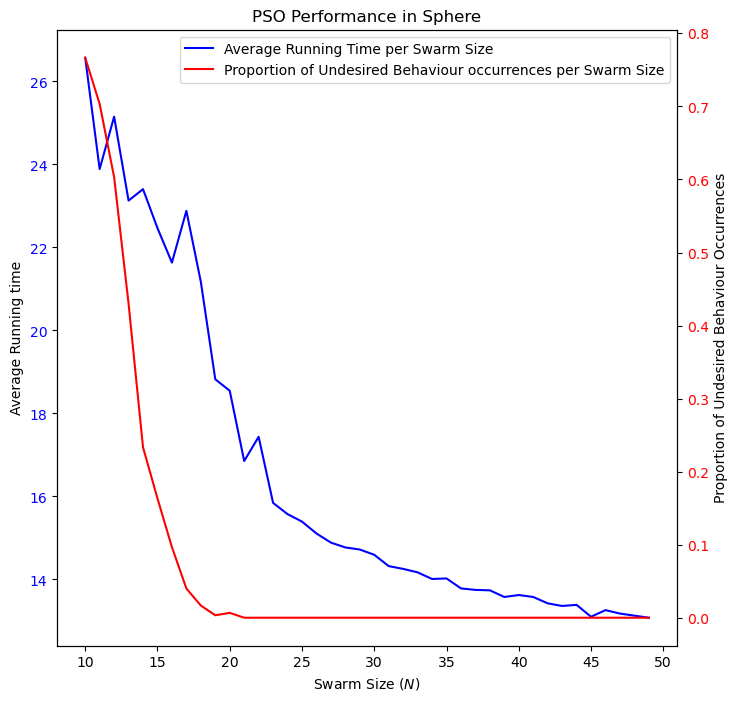

In [48]:
# for the sphere with timing in seconds and iterations:
rangeN=range(10,50)
times=list()
undesired=list()
seconds=list()
for N in rangeN: 
    c=0
    sumatimes=0
    sumadiver=0
    sumaseconds=0
    for it in range(300): #the average time we take will be taken over 300 sets
        
            t_start=process_time() #for timing in seconds
            results=PSO(0.3, 1., 1., 4, N, 5.12, sphere, 0.00001).run()
            t_stop=process_time()
            time, diver=results
            
            if time==None: 
                sumadiver=sumadiver+1
            else: 
                sumatimes=sumatimes+time
                sumaseconds=sumaseconds+t_stop-t_start
                c=c+1
                
    averagetime=sumatimes/(c+0.00000000001)#the 0.0000000001 is added to avoid division by 0.
    averagediver=sumadiver/300
    averageseconds=sumaseconds/(c+0.00000000001)
    
    times.append(averagetime)
    undesired.append(averagediver)
    seconds.append(averageseconds)

fig=plt.figure(figsize=(8,8))
ax=plt.subplot(111)

ax.set_xlabel("Swarm Size ($N$)")
ax.set_ylabel("Average Running time")
plot=ax.plot(rangeN, times,color="blue", label="Average Running Time per Swarm Size")
ax.tick_params(axis ='y', labelcolor = 'blue')

# We use the twinx method to plot in two y-axes.
ax2=ax.twinx()
ax2.set_ylabel("Proportion of Undesired Behaviour Occurrences")
plot2=ax2.plot(rangeN, undesired, color="red", label="Proportion of Undesired Behaviour occurrences per Swarm Size")
ax2.tick_params(axis ='y', labelcolor = 'red')

plots = plot + plot2
labels = [l.get_label() for l in plots]
plt.legend(plots, labels, loc="best")
plt.title("PSO Performance in Sphere")
plt.show()
# plt.savefig("PSO_on_sphere_wrt_N.png")

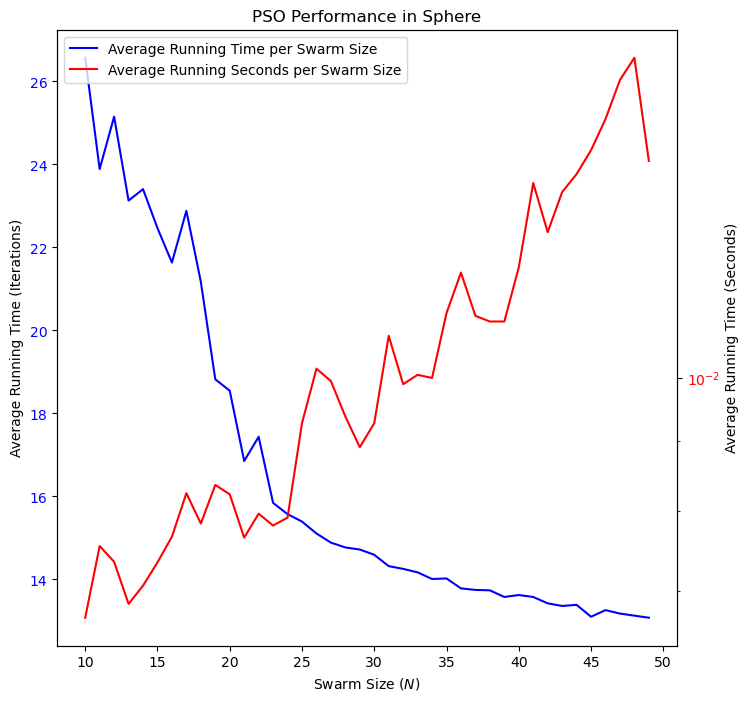

In [49]:
# for the sphere with timining in seconds and iterations visualization
fig=plt.figure(figsize=(8,8))
ax=plt.subplot(111)

ax.set_xlabel("Swarm Size ($N$)")
ax.set_ylabel("Average Running Time (Iterations)")
plot=ax.plot(rangeN, times,color="blue", label="Average Running Time per Swarm Size")
ax.tick_params(axis ='y', labelcolor = 'blue')

# We use the twinx method to plot in two y-axes.
ax2=ax.twinx()
ax2.set_ylabel("Average Running Time (Seconds)")
ax2.set_yscale("log")
plot2=ax2.plot(rangeN, seconds, color="red", label="Average Running Seconds per Swarm Size")
ax2.tick_params(axis ='y', labelcolor = 'red')

plots = plot + plot2
labels = [l.get_label() for l in plots]
plt.legend(plots, labels, loc="best")
plt.title("PSO Performance in Sphere")
plt.show()


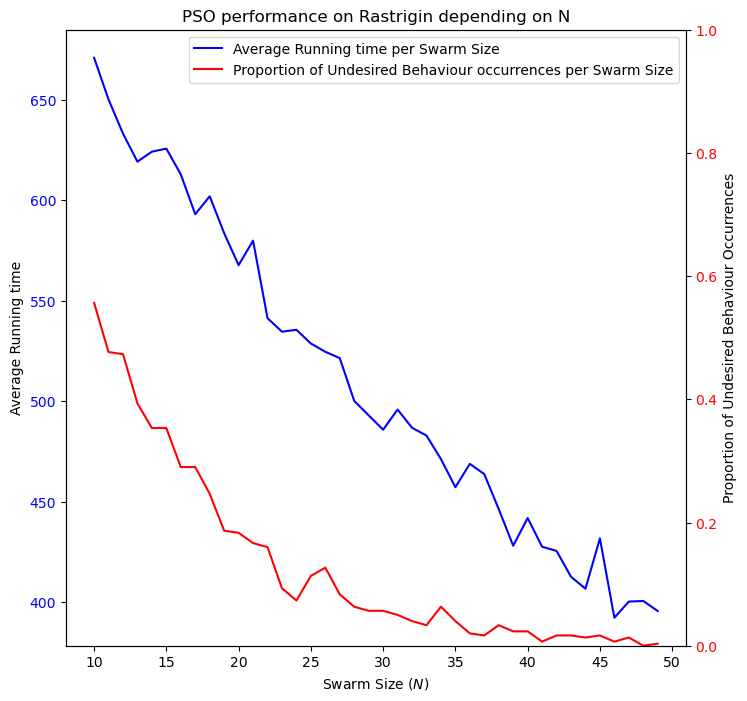

In [52]:
# for the rastrigin:
rangeN=range(10,50)
times=list()
undesired=list()
seconds=list()
for N in rangeN: 
    c=0
    sumatimes=0
    sumadiver=0
    sumaseconds=0
    for it in range(300):#the average time we take will be taken over 300 sets
        
            t_start=process_time() #for timing in seconds
            results=PSO(0.7, 2., 2., 4, N, 5.12, rastrigin, 0.00001).run()
            t_stop=process_time()
            time, diver=results
            
            if time==None: 
                sumadiver=sumadiver+1
            else: 
                sumatimes=sumatimes+time
                sumaseconds=sumaseconds+t_stop-t_start
                c=c+1
    averagetime=sumatimes/(c+0.00000000001)#the 0.0000000001 is added to avoid division by 0.
    averagediver=sumadiver/300
    averageseconds=sumaseconds/(c+0.00000000001)
        
    times.append(averagetime)
    undesired.append(averagediver)        
    seconds.append(averageseconds)

fig=plt.figure(figsize=(8,8))
ax=plt.subplot(111)

ax.set_xlabel("Swarm Size ($N$)")
ax.set_ylabel("Average Running time")
plot=ax.plot(rangeN, times, color="blue", label="Average Running time per Swarm Size")
ax.tick_params(axis ='y', labelcolor = 'blue')

# We use the twinx method to plot in two y-axes.
ax2=ax.twinx()
ax2.set_ylabel("Proportion of Undesired Behaviour Occurrences")
ax2.set_ylim(0,1)
plot2=ax2.plot(rangeN, undesired, color="red", label="Proportion of Undesired Behaviour occurrences per Swarm Size")
ax2.tick_params(axis ='y', labelcolor = 'red')

plt.title("PSO performance on Rastrigin depending on N")

plots = plot + plot2
labels = [l.get_label() for l in plots]
plt.legend(plots, labels, loc="best")


plt.show()
# plt.savefig("PSO_on_Rastrigin_wrt_N.png")

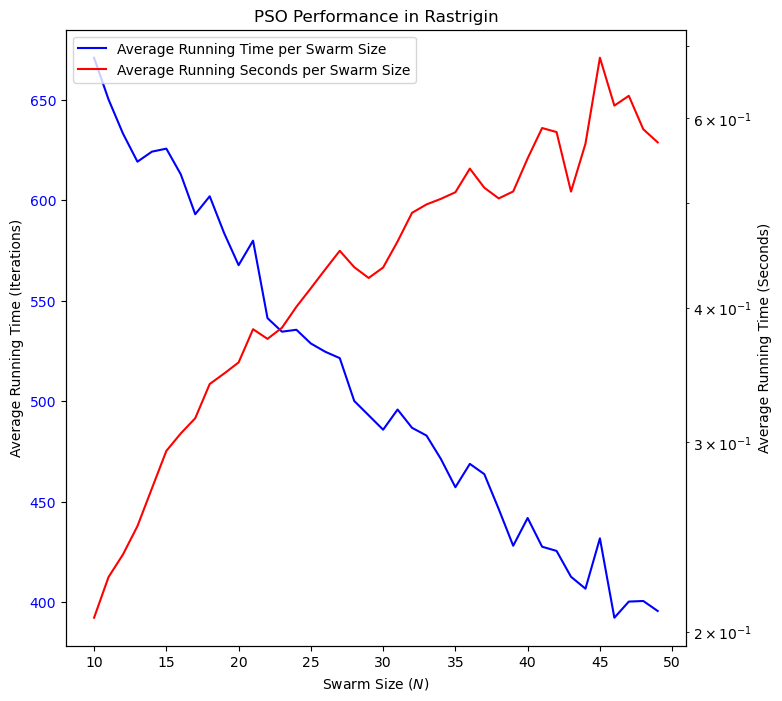

In [53]:
# for the rastrigin with timing in seconds and iterations:  
fig=plt.figure(figsize=(8,8))
ax=plt.subplot(111)

ax.set_xlabel("Swarm Size ($N$)")
ax.set_ylabel("Average Running Time (Iterations)")
plot=ax.plot(rangeN, times,color="blue", label="Average Running Time per Swarm Size")
ax.tick_params(axis ='y', labelcolor = 'blue')

# We use the twinx method to plot in two y-axes.
ax2=ax.twinx()
ax2.set_ylabel("Average Running Time (Seconds)")
ax2.set_yscale("log")
plot2=ax2.plot(rangeN, seconds, color="red", label="Average Running Seconds per Swarm Size")
ax2.tick_params(axis ='y', labelcolor = 'red')

plots = plot + plot2
labels = [l.get_label() for l in plots]
plt.legend(plots, labels, loc="best")
plt.title("PSO Performance in Rastrigin")
plt.show()

## Exercise 3: Heterogeneous Particle Swarms 

In [52]:
class ParticleA: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx, funct):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim
        self.funct=funct
        self.fitness = self.funct(self.position)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = self.funct(pos)  #WATCH OUT WITH THIS LINE: Is it self.position or just pos?
        
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, best_self_pos, best_swarm_pos):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
                    # the next line is the main equation, namely the velocity update, 
                    # the velocities are added to the positions at swarm level
        new_vel = inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)
        self.velocity = new_vel
        return new_vel
    
    

#In these lines of codes, I add another argument to the particle class created in the labs, which determines the function in which our swarm particles are evaluated. 
#Hence, when optimising a particular function f, we will call our particles with funct=f.

In [52]:
class ParticleB: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx, funct):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim
        self.funct=funct
        self.fitness = self.funct(self.position)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = self.funct(pos)  #WATCH OUT WITH THIS LINE: IS IT self.position or just pos?
        
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, best_self_pos, best_swarm_pos):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
                    # the next line is the main equation, namely the velocity update, 
                    # the velocities are added to the positions at swarm level
        new_vel = inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)
        self.velocity = new_vel
        return new_vel

#In these lines of codes, I add another argument to the particle class created in the labs, which determines the function in which our swarm particles are evaluated. 
#Hence, when optimising a particular function f, we will call our particles with funct=f.

In [54]:
class HetPSO: # all the material that is relavant at swarm leveel

    def __init__(self, wA, aA1, aA2, wB, aB1, aB2 dim, population_size, search_range, f, termination):

        # Here we use values that are (somewhat) known to be good
        # There are no "best" parameters (No Free Lunch), so try using different ones
        # There are several papers online which discuss various different tunings of a1 and a2
        # for different types of problems
        
        self.wA = wA # Inertia class A particles
        self.aA1 = aA1 # Attraction to personal best of swarm A
        self.aA2 = aA2 # Attraction to global best of swarm A
        
        self.wB = wB # Inertia class B particles
        self.aB1 = aB1 # Attraction to personal best of swarm B
        self.aB2 = aB2 # Attraction to global best of swarm B
        
        self.dim = dim
        self.f=f
        self.termination=termination # a termination threeshold.
        self.population_A=population_size//2
        self.population_B=population_size-self.population_A
        self.swarmA = [ParticleA(dim,-search_range,search_range, self.f) for i in range(self.population_A)]
        self.swarmB=[ParticleB(dim,-search_range,search_range, self.f) for i in range(self.population_B)]
        self.swarms=[self.swarmA, self.swarmB]

        # Initialising global best, you can wait until the end of the first time step
        # but creating a random initial best and fitness which is very high will mean you
        # do not have to write an if statement for the one off case
        self.best_swarmA_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarmA_fitness = 1e100
        
        self.best_swarmB_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarmB_fitness = 1e100
        

    def run(self): 
        time=0
        diver=0
        while self.best_swarmA_fitness>self.termination and self.best_swarmB_fitness>self.termination:
            time=time+1
            if time==1000: 
                    return [None,1]# To avoid to much time running.
                
            for p in range(len(self.swarmA)):
                particle = self.swarmA[p]

                new_position = particle.position + particle.updateVel(self.wA, self.aA1, self.aA2, particle.best_particle_pos, self.best_swarmA_pos)
                                
                if new_position.dot(new_position) > 1.0e+18: # The search will be terminated if the distance 
                                                        # of any particle from center is too large
                        # We would want parameters for which our swarm does not diverge. As we also do not want 
                        # parameter settings producing time consuming runs, we group these two options by making divergent swarms look as time consuming runs
                        #print('Time:', time,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                        #This will tell us whether the swarm diverged or not.
                        #'Most likely divergent: Decrease parameter values'
                    return [None, 1] #if our new particle position is too far apart, we simply return a None time value and a 1 divergence value.
                        #This will state that most likely our swarm diverged and consequently there is no proper convergence of the swarm.
                
                self.swarmA[p].setPos(new_position)         #When executing this recall that you are also maybe updating the value of the particle's best.

                new_fitness = self.f(new_position)

                if new_fitness < self.best_swarmA_fitness:   # to update the global best both 
                                                            # position (for velocity update) and
                                                            # fitness (the new group norm) are needed
                    self.best_swarmA_fitness = new_fitness
                    self.best_swarmA_pos = new_position
                    
            for p in range(len(self.swarmB)):
                particle = self.swarmB[p]

                new_position = particle.position + particle.updateVel(self.wB, self.aB1, self.aB2, particle.best_particle_pos, self.best_swarmB_pos)
                                
                if new_position.dot(new_position) > 1.0e+18: # The search will be terminated if the distance 
                                                        # of any particle from center is too large
                        # We would want parameters for which our swarm does not diverge. As we also do not want 
                        # parameter settings producing time consuming runs, we group these two options by making divergent swarms look as time consuming runs
                        #print('Time:', time,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                        #This will tell us whether the swarm diverged or not.
                        #'Most likely divergent: Decrease parameter values'
                    return [None, 1] #if our new particle position is too far apart, we simply return a None time value and a 1 divergence value.
                        #This will state that most likely our swarm diverged and consequently there is no proper convergence of the swarm.
                
                self.swarmB[p].setPos(new_position)         #When executing this recall that you are also maybe updating the value of the particle's best.

                new_fitness = self.f(new_position)

                if new_fitness < self.best_swarmB_fitness:   # to update the global best both 
                                                            # position (for velocity update) and
                                                            # fitness (the new group norm) are needed
                    self.best_swarmB_fitness = new_fitness
                    self.best_swarmB_pos = new_position
             
                
        return [time, diver]
                
# review time and diver variables.


In [ ]:
HetPSO(0.3,1,1,0.7,2,2,4,50,5.12,rastrigin,0.0001)

## Exercise 4: Differential Evolution

In [307]:
class DifferentialEvolution:
    def __init__(self,dim, F, prob, size, minx, maxx, funct):
        self.dim=dim
        self.F=F
        self.prob=prob
        self.size=size
        self.minx=minx
        self.maxx=maxx
        self.funct=funct
        self.population=[np.random.uniform(low=self.minx, high=self.maxx, size=self.dim) for n in range(self.size)]
    
    def newpopulation(self):
        for n in range(self.size):
            individual=self.population[n]
            v=np.zeros(self.dim)
            three_parents=random.sample(self.population,3)
#             print(three_parents)
            if self.funct(three_parents[0])>self.funct(three_parents[1]):
                copy_individual=individual
                v=three_parents[2]+self.F*(three_parents[1]-three_parents[0])
                for dimension in range(self.dim):
                    if np.random.uniform()<self.prob:
                        copy_individual[dimension]=v[dimension]
                        
                if self.funct(copy_individual)<self.funct(individual):
                    print(self.funct(individual))
                    print(self.funct(copy_individual))
                    self.population[n]=copy_individual
                    
    def run(self, term_criterion, max_iterations):
        time=0
        while (min(np.apply_along_axis(self.funct, 0, self.population))>term_criterion) and time<=max_iterations:
            time=time+1
            self.newpopulation()
        return min(np.apply_along_axis(self.funct, 0, self.population))

In [454]:
DifferentialEvolution(4,0.25,1, 8,-5.12,5.12,sphere).run(0.0001,70)
# .run(0.0001,20)
# np.random.uniform(2,3,size=3)
# Carefull with the specific parameters that you use. Choose the parameters as indicated in the lectures. 


0.0028207519260877853